In [202]:
import numpy as np
import matplotlib.pyplot as plt
import pyDOE2
from GPy.kern import RBF
import matplotlib
from math import sqrt
SPINE_COLOR = 'gray'

In [203]:
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': [r'\usepackage{gensymb}'],
              'axes.labelsize': 11, # fontsize for x and y labels (was 10)
              'axes.titlesize': 11,
              'font.size': 11, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 9,
              'ytick.labelsize': 9,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)


def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

 /home/patel_zeel/anaconda3/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning:Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.


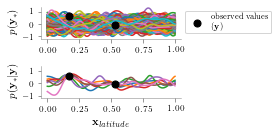

In [205]:
latexify(4,2)
N = 1000
FN = 1000
np.random.seed(2)
x = np.array(sorted(pyDOE2.doe_lhs.lhs(1, N))).reshape(-1,1)
xt_ind = np.random.choice(x.shape[0], 2) # Observed index
k = RBF(1, lengthscale=0.05, variance=0.08)
cov = k.K(x)
y = np.random.multivariate_normal(np.zeros(N), cov, size=FN)

fig, ax = plt.subplots(2,1,sharex=True, sharey=True)
for ind in range(FN):
    ax[0].plot(x, y[ind,:]);
ax[0].scatter(x[xt_ind], y[0,xt_ind],c='k',s=50,zorder=10,label='observed values\n($\mathbf{y}$)')
### Plotting posterior
# filtering functions that passes through observed values
y_ind = np.arange(y.shape[0])[np.all(np.abs(y[0,xt_ind]-y[:,xt_ind])<0.1, axis=1)]
ax[1].scatter(x[xt_ind], y[0,xt_ind],c='k',s=50,zorder=10)
for ind in y_ind:
    ax[1].plot(x, y[ind,:]);
ax[0].set_ylabel('$p(\mathbf{y_*})$');
ax[1].set_xlabel('$\mathbf{x}_{latitude}$');
ax[1].set_ylabel('$p(\mathbf{y_*|y})$');
ax[0].legend(bbox_to_anchor=(1,1));

format_axes(ax[0])
format_axes(ax[1])
plt.tight_layout();
plt.savefig('figures/prior-post.pdf')

 /home/patel_zeel/anaconda3/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning:Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.


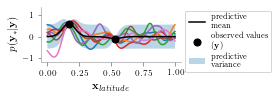

In [206]:
latexify(4,1.5)
fig2, ax2 = plt.subplots()
ax2.set_ylim(*ax[0].get_ylim())
post_mean = (cov[:,xt_ind]@np.linalg.inv(cov[np.ix_(xt_ind,xt_ind)])@y[0,xt_ind].reshape(-1,1)).squeeze()
post_cov = cov - cov[:,xt_ind]@np.linalg.inv(cov[np.ix_(xt_ind,xt_ind)])@cov[xt_ind,:]
post_std2 = np.sqrt(post_cov.diagonal())*2
for ind in y_ind:
    ax2.plot(x, y[ind,:]);
ax2.scatter(x[xt_ind], y[0,xt_ind],c='k',s=50,zorder=10,label='observed values\n($\mathbf{y}$)')
ax2.plot(x, post_mean,color='k',label='predictive\nmean');
ax2.fill_between(x.squeeze(),post_mean-post_std2, post_mean+post_std2, alpha=0.3, label='predictive\nvariance');
ax2.legend(bbox_to_anchor=[1,1]);
ax2.set_xlabel('$\mathbf{x}_{latitude}$');
ax2.set_ylabel('$p(\mathbf{y_*|y})$');

format_axes(ax2)
plt.tight_layout()
plt.savefig('figures/predictive-MeanVar.pdf')